In [163]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

In [164]:
# Find the continuous interval for each label
def get_intervals(labels):
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'begin' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'begin' : i,
        'end' : l
    })

    return intervals

In [276]:
# Extract the top (amp, freq) from the signal
# where (amp, freq) is sorted by amp

def extract_features(signal, n = 8):
    coeffs = fft.fft(signal)
    l = len(coeffs)   
    freqs = fft.fftfreq(l)
    
    # Discard half the array since it's a mirror
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])

    n = min(n, l)

    if n == 0 :
        return np.array([])
    
    # Sort the freqs w.r.t amp   
    p = amps.argsort()
    freqs = freqs[p][::-1]
    amps = amps[p][::-1]
    
    # Return the top n (amp, freq)
    d = n
    features = [[amps[i], freqs[i]] for i in range(d)]
    features += [[amps[l - i -1], freqs[l - i -1]] for i in range(n - d)]

    return np.array(features)

In [277]:
# Extract the signal features, given the sampling rate and window_len
# There's 50% overlap in the windows

def get_signal_sample_features(signal, intervals, sampling_rate = 700, window_len = 30, num_features = 8):
    samples = (sampling_rate*window_len)
    baseline_av = 0
    sample_features = {
        1 : [],
        2 : [],
        3 : [],
        4 : []
    }

    for interval in intervals :
        label = interval['label']
        begin = interval['begin']
        end = interval['end']

        if label > 4 :
            continue
    
        part_of_signal = signal[begin : end]

        if label == 0 :
            baseline_av = np.mean(part_of_signal)
            continue
        
        # Remove the baseline average
        part_of_signal -= baseline_av
        
        l = end-begin
        while l > 0 :
            sub_part = part_of_signal[max(0, l-samples) : l]
            l -= samples // 3

            features = extract_features(sub_part, num_features)
            if len(features) != num_features :
                continue
            sample_features[label].append(features)
    
    return sample_features

In [278]:
def read_subject_data(s_no) :
    path = '../WESAD/S' + str(s_no) + '/S' + str(s_no) + '.pkl'
    subject = pd.read_pickle(path)

    return subject

In [279]:
def get_chest_sample_features(subject) :
    chest_signals = subject['signal']['chest']
    labels = subject['label']
    intervals = get_intervals(labels)
    signal_features = {}
    for signal_type in chest_signals :
        if signal_type == 'ACC' :
            continue
        
        signal = np.array(chest_signals[signal_type]).flatten()
        sample_features = get_signal_sample_features(signal, intervals)
        signal_features[signal_type] = sample_features
        
    return signal_features

In [280]:
def convert_to_df(chest_signal_features) :
    signal_df = {}
    for signal_type, sample_features in chest_signal_features.items() :
        df = pd.DataFrame(columns=['label', 'amp', 'freq'])
        for label, features in sample_features.items() :
            for points in features:
                df = df.append({
                        'label' : label,
                        'amp' : points[0][0],
                        'freq' : points[0][1]
                    }, ignore_index=True)

        signal_df[signal_type] = df
    return signal_df

In [281]:
subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

global_chest_signal_features = {}

for subject in subjects :
    subject= read_subject_data(subject)
    chest_signal_features = get_chest_sample_features(subject)

    for signal_type in chest_signal_features :
        if signal_type not in global_chest_signal_features :
            global_chest_signal_features[signal_type] = {}
        
        for label in chest_signal_features[signal_type] :
            if label not in global_chest_signal_features[signal_type] :
                global_chest_signal_features[signal_type][label] = []
                
            global_chest_signal_features[signal_type][label] += chest_signal_features[signal_type][label]

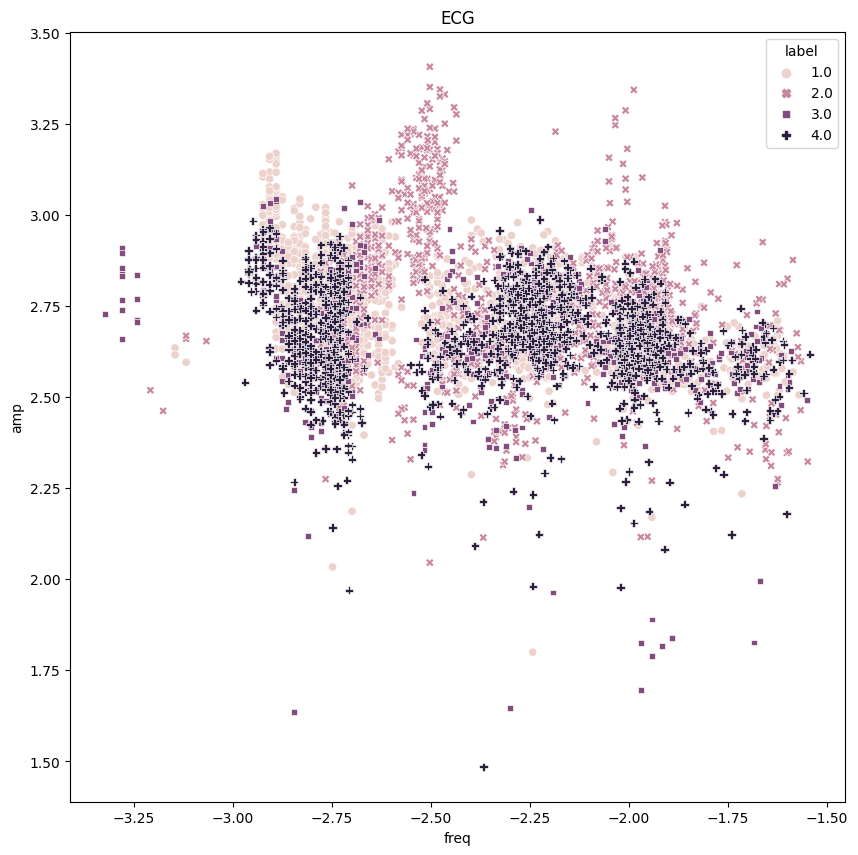

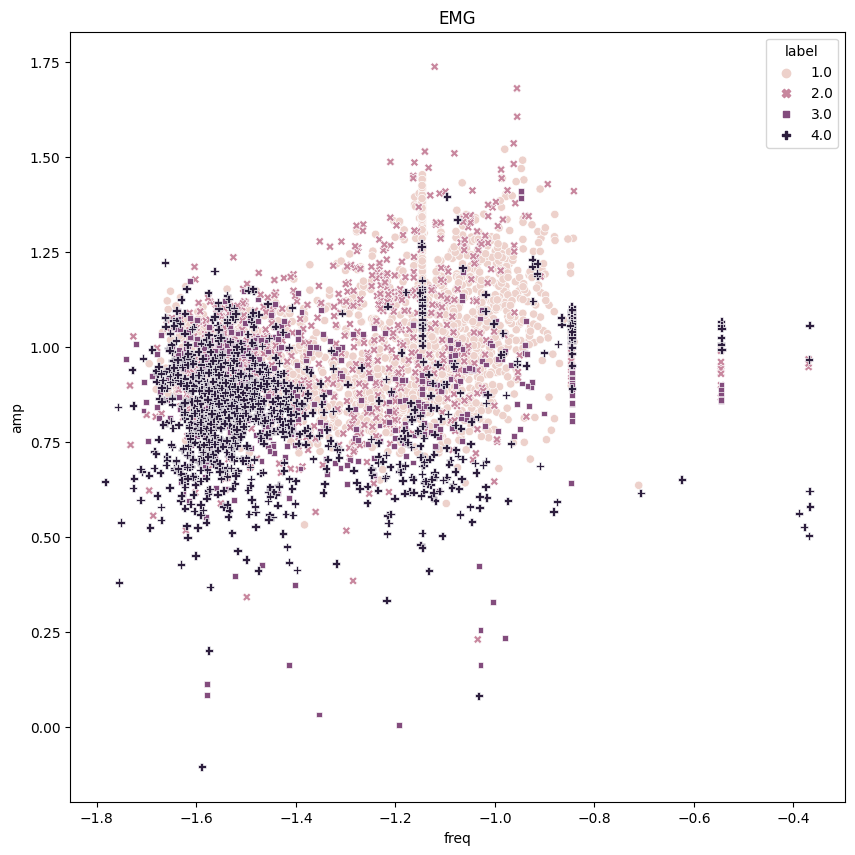

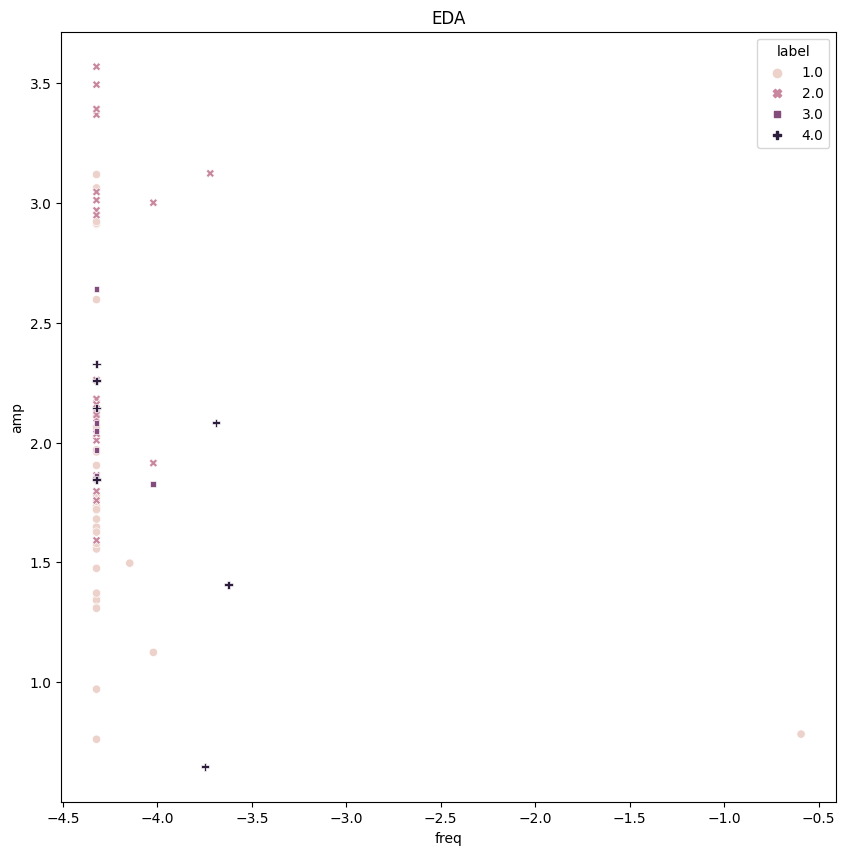

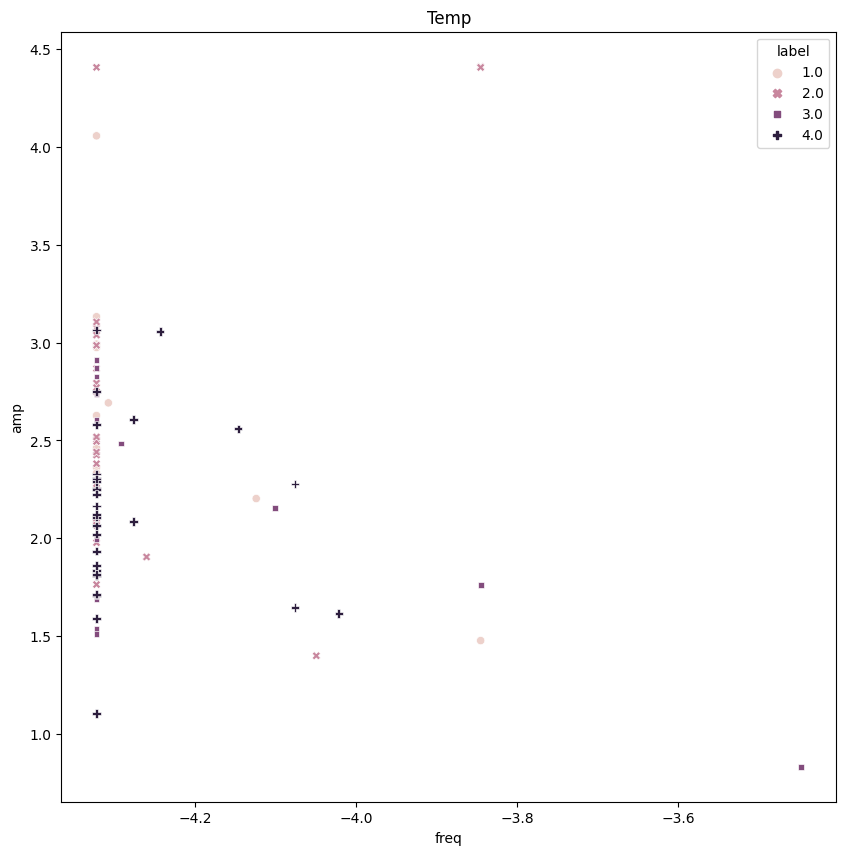

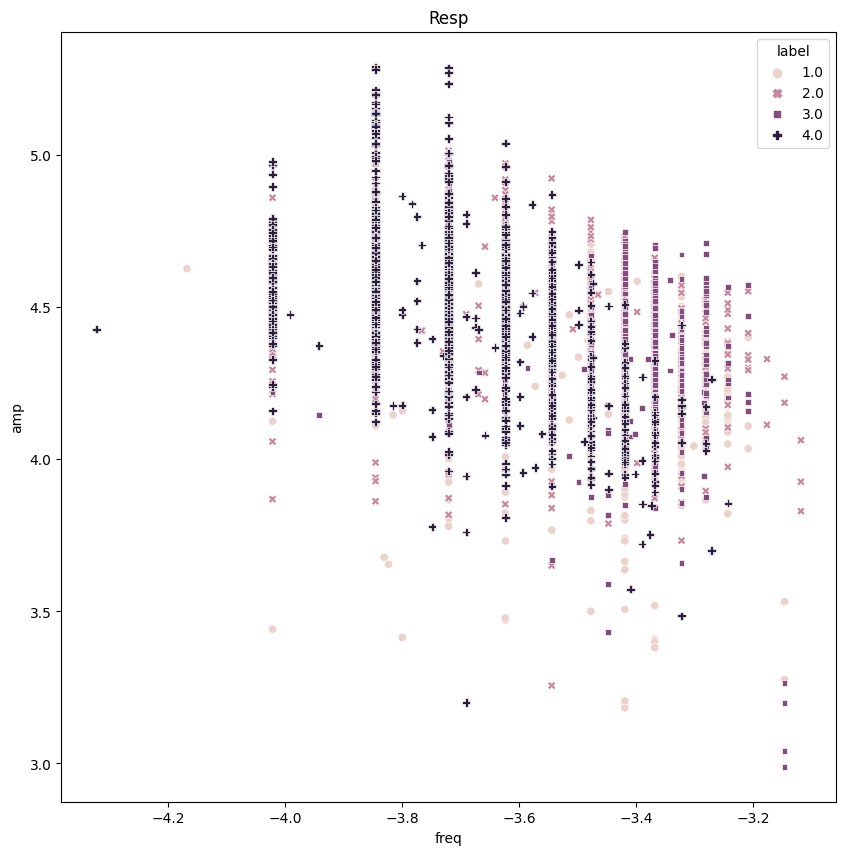

In [282]:
plt.style.use('default')

signal_df = convert_to_df(global_chest_signal_features)

for signal_type, df in signal_df.items() :
    df = df.copy()
    df[['amp', 'freq']] = np.log10(df[['amp', 'freq']])
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data = df, x = 'freq', y = 'amp', hue = 'label', style= 'label').set(title=signal_type)

In [283]:
df = signal_df['ECG']
features = np.log10(df[['amp', 'freq']]).to_numpy()
labels = df['label'].to_numpy().flatten()

In [284]:
def get_features_labels(signal_features) :
    label_cluster = {
        1 : [],
        2 : [],
        3 : [],
        4 : [],
    }

    for _, labelled_signal in signal_features.items() :
        for label, clusters in labelled_signal.items() :
            l = len(clusters)
            if len(label_cluster[label]) != l :
                for i in range(l) :
                    label_cluster[label].append([])

            for i in range(l):
                label_cluster[label][i].append(clusters[i])

    features = []
    labels = []

    for label, clusters in label_cluster.items() :
        for feature in clusters :
            features.append(feature)
            labels.append(label)

    return np.array(features), np.array(labels)

In [285]:
features, labels = get_features_labels(global_chest_signal_features)

In [286]:
features.shape

(4524, 5, 8, 2)

In [287]:
shape = features.shape
for i in range(shape[1]) :
    for j in range(shape[3]) :        
        for k in range(shape[2]):
            m = 0
            var = 0
            
            for l in range(shape[0]) :
                m +=  features[l][i][k][j]
            
            m /= shape[0]
            
            for l in range(shape[0]) :
                var +=  (features[l][i][k][j] - m)**2
            
            std = sqrt(var/shape[0])
            
            for l in range(shape[0]) :
                features[l][i][k][j] /= std


In [288]:
print(len(global_chest_signal_features['ECG'][4]))

1191


In [289]:
from sklearn.model_selection import train_test_split

In [290]:
encoder = {
    1 : [1, 0, 0, 0],
    2 : [0, 1, 0, 0],
    3 : [0, 0, 1, 0],
    4 : [0, 0, 0, 1]
}

one_hot_encoded_labels = np.array([encoder[x] for x in labels])
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25)
print(len(features_train), len(features_test), len(labels_train), len(labels_test))

3393 1131 3393 1131


In [291]:
import tensorflow as tf
from tensorflow import keras

In [292]:
model = keras.Sequential([
    keras.layers.Conv2D(3, (3, 3), activation ='swish', input_shape=(5, 8, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=40,  activation='swish'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=40,  activation='swish'),
#     keras.layers.Dropout(0.2),
    keras.layers.Dense(units=20,  activation='swish'),
    keras.layers.Dense(units=4)
])

In [293]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 3, 6, 3)           57        
_________________________________________________________________
flatten_44 (Flatten)         (None, 54)                0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 54)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 40)                2200      
_________________________________________________________________
dropout_89 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_161 (Dense)            (None, 20)              

In [294]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [295]:
c = {
    1 : 0,
    2 : 1,
    3 : 0,
    4 : 0
}

for label in labels_test :
    if np.array_equal(label, [1, 0, 0, 0]) :
        c[1] += 1
    if np.array_equal(label, [0, 1, 0, 0]) :
        c[2] += 1
    if np.array_equal(label, [0, 0, 1, 0]) :
        c[3] += 1
    if np.array_equal(label, [0, 0, 0, 1]) :
        c[4] += 1
        
c

{1: 458, 2: 245, 3: 135, 4: 294}

In [296]:
i = 0
while True :
    i += 2
    s = max(35 - i, 5)
    model.fit(features_train, labels_train, epochs=300,  batch_size=s, shuffle=True, verbose=0)
    model.evaluate(features_test,  labels_test)

36/36 [==============================] - 0s 827us/step - loss: 0.1872 - accuracy: 0.9408


KeyboardInterrupt: 

In [ ]:
np.equal([1, 0, 0, 0], [1, 0, 0, 0])

In [ ]:
print(len(train_features), len(test_features))